In [1]:
!pip install matplotlib

In [2]:
import cv2 
import numpy as np 
import random 
import os 
import matplotlib.pyplot as plt 

In [3]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, Layer, Input
import tensorflow as tf

In [4]:
POS_PATH = os.path.join('data', 'positive')
NEG_PATH = os.path.join('data', 'negative')
ANC_PATH = os.path.join('data', 'anchor')

In [6]:
#os.makedirs(POS_PATH)
#os.makedirs(NEG_PATH)
#os.makedirs(ANC_PATH)

In [7]:
for directory in os.listdir('lfw'):
    if directory == '.DS_Store':
        continue
    for file in os.listdir(os.path.join('lfw', directory)):
        ex_path = os.path.join('lfw', directory, file)
        new_path = os.path.join(NEG_PATH, file)
        os.replace(ex_path, new_path)

In [8]:
import uuid

In [9]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    frame = frame[450:900, 750:1200, :]

    if cv2.waitKey(1) & 0XFF == ord('a'):
        img_name = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
        cv2.imwrite(img_name, frame)

    if cv2.waitKey(1) & 0XFF == ord('p'):
        img_name = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
        cv2.imwrite(img_name, frame)        
    
    cv2.imshow('Image Collection', frame)
    
    if cv2.waitKey(1) & 0XFF == ord('q'):
        break 
cap.release()
cv2.destroyAllWindows()

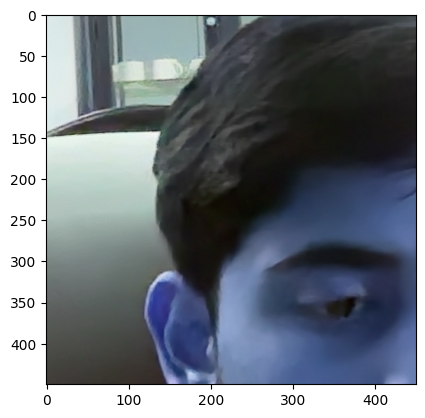

In [10]:
plt.imshow(frame)

In [11]:
frame.shape

(450, 450, 3)

In [12]:
anchor = tf.data.Dataset.list_files(ANC_PATH + '/*.jpg').take(300)
positive= tf.data.Dataset.list_files(POS_PATH + '/*.jpg').take(300)
negative = tf.data.Dataset.list_files(NEG_PATH + '/*.jpg').take(300)

In [13]:
def preprocess(file_path): 
    byte_img = tf.io.read_file(file_path) 
    img = tf.io.decode_jpeg(byte_img)
    img = tf.image.resize(img, (100,100))
    img = img/255
    return img

In [14]:
dir_test = anchor.as_numpy_iterator()
dir_test.next()

b'data/anchor/d795aace-6792-11f0-8ad3-b2f4ed02152c.jpg'

(100, 100, 3)


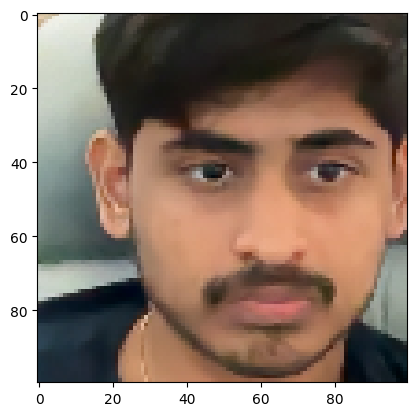

In [15]:
img = preprocess('data/anchor/07a799fa-679f-11f0-8ad3-b2f4ed02152c.jpg')
plt.imshow(img)
print(img.shape)

In [16]:
positives = tf.data.Dataset.zip(anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor))))
negatives = tf.data.Dataset.zip(anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor))))
data = positives.concatenate(negatives)

In [17]:
samples = data.as_numpy_iterator()
example = samples.next()

In [18]:
def preprocess_twin(input_img, validation_img, label):
    return (preprocess(input_img), preprocess(validation_img), label)

In [19]:
res = preprocess_twin(*example)

In [20]:
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size = 1024)

In [25]:
train_data = data.take(round(len(data) *.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [24]:
test_data = data.skip(round(len(data) * .7))
test_data = data.take(round(len(data) *.3))
test_data = test_data.batch(16) 
test_data = test_data.prefetch(8)

In [31]:
inp = Input(shape = (100,100,3), name = 'input_image')
c1 = Conv2D(filters = 64, kernel_size= (10,10), activation = 'relu')(inp)
c1

<KerasTensor shape=(None, 91, 91, 64), dtype=float32, sparse=False, ragged=False, name=keras_tensor>

In [33]:
p1 = MaxPooling2D(pool_size = (2,2))(c1)
c2 = Conv2D(filters = 128, kernel_size = (7,7), activation = 'relu')(p1)
p2 = MaxPooling2D(pool_size = (2,2))(c2)
c3 = Conv2D(filters = 128, kernel_size = (4,4), activation = 'relu')(p2)
p3 = MaxPooling2D(pool_size = (2,2))(c3)
c4 = Conv2D(filters = 256, kernel_size = (4,4),activation = 'relu')(p3)
c4

<KerasTensor shape=(None, 5, 5, 256), dtype=float32, sparse=False, ragged=False, name=keras_tensor_12>

In [61]:
def make_embedding():
    inp = Input(shape = (100,100,3), name = 'input_image')
    c1 = Conv2D(filters = 64, kernel_size = (10,10), activation = 'relu')(inp)
    p1 = MaxPooling2D(64, (2,2), padding = 'same')(c1)
    c2 = Conv2D(filters = 128, kernel_size = (7,7), activation = 'relu')(p1)
    p2 = MaxPooling2D(64, (2,2), padding = 'same')(c2)
    c3 = Conv2D(filters = 128, kernel_size = (4,4), activation = 'relu')(p2)
    p3 = MaxPooling2D(64,(2,2), padding = 'same')(c3)
    c4 = Conv2D(filters = 256, kernel_size = (4,4),activation = 'relu')(p3) 
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation = 'sigmoid')(f1)
    return Model(inputs = inp, outputs = d1, name = 'embedding')

In [62]:
embedding = make_embedding()
embedding.summary()

Model: "embedding"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)        │ (None, 100, 100, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 91, 91, 64)     │        19,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 46, 46, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 40, 40, 128)    │       401,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 17, 17, 128)    │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 9, 9, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_24 (Conv2D)              │ (None, 6, 6, 256)      │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4096)           │    37,752,832 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,960,448 (148.62 MB)

 Trainable params: 38,960,448 (148.62 MB)

 Non-trainable params: 0 (0.00 B)

In [63]:
class L1Dist(Layer):
    def __init__(self, **kwargs):
        super().__init__()
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

In [67]:
l1 = L1Dist()
l1(input_embed, val_embed)

<KerasTensor shape=(None, 4096), dtype=float32, sparse=False, ragged=False, name=keras_tensor_62>

In [71]:
def make_siamese_model():
    input_img = Input(shape = (100,100,3), name = 'input_image')
    validation_img = Input(shape = (100,100,3), name = 'validation_image')

    siamese_layer = L1Dist()
    siamese_layer._name = 'distances'
    distances = siamese_layer(embedding(input_img), embedding(validation_img))
    classifier = Dense(1, activation = 'sigmoid')(distances)

    return Model(inputs = [input_img, validation_img], outputs = classifier, name = 'Siamese-model')
    

In [66]:
input_img = Input(shape = (100,100,3), name = 'input_image')
validation_img = Input(shape = (100,100,3), name = 'validation_image')

input_embed = embedding(input_img)
val_embed = embedding(validation_img)
val_embed

<KerasTensor shape=(None, 4096), dtype=float32, sparse=False, ragged=False, name=keras_tensor_61>

In [68]:
siamese_layer = L1Dist()
siamese_layer(input_embed, val_embed)

<KerasTensor shape=(None, 4096), dtype=float32, sparse=False, ragged=False, name=keras_tensor_63>

In [74]:
distances = siamese_layer(embedding(input_img), embedding(validation_img))

In [75]:
classifier = Dense(1, activation = 'sigmoid')(distances)

In [76]:
siamese_network = Model(inputs = [input_img, validation_img], outputs = classifier, name = 'Siamese-model')

In [77]:
siamese_network.summary()

Model: "Siamese-model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_image         │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ validation_image    │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 4096)      │ 38,960,448 │ input_image[0][0… │
│ (Functional)        │                   │            │ validation_image… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ l1_dist_5 (L1Dist)  │ (None, 4096)      │          0 │ embedding[2][0],  │
│                     │                   │            │ embedding[3][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 1)         │      4,097 │ l1_dist_5[1][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 38,964,545 (148.64 MB)

 Trainable params: 38,964,545 (148.64 MB)

 Non-trainable params: 0 (0.00 B)